In [118]:
from __future__ import annotations

import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import plotly.express as px

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

In [75]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorbarbarich/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Представление и предобработка текстовых данных 

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [76]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer

In [77]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [78]:
def preprocess_text(_text: str) -> str:
    """
    Приводит строку к нижнему регистру и заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел
    """
    pattern = re.compile(r'[^a-zA-Z,.?!]')
    _text = _text.lower()
    _text = re.sub(pattern, ' ', _text)
    return _text


preprocess_text(text)

'select your preferences and run the install command. stable represents the most currently tested and supported version of pytorch. note that libtorch is only available for c  '

1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [79]:
def get_binary_coded_arr(words: list[str], _word_bag: list[str]) -> list[int]:
    """
    Возвращает массив из 0 или 1

    :param words: слова из предложения
    :param _word_bag: общий набор всех слов
    :return: список из 0 и 1
    """

    return [(word in _word_bag) * 1 for word in words]


word_bag = list(set(preprocess_text(text).split()))
sentence_1 = get_binary_coded_arr(text.split('.')[0], word_bag)

print(word_bag)
print(sentence_1)

['most', 'command.', 'run', 'the', 'select', 'available', 'tested', 'preferences', 'for', 'version', 'is', 'your', 'of', 'that', 'libtorch', 'c', 'and', 'currently', 'only', 'stable', 'note', 'install', 'represents', 'supported', 'pytorch.']
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`. 

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [80]:
# 1
surnames = pd.read_csv('data/surnames.csv')
surnames.head(2)

,surname,nationality
0,Woodford,English
1,Coté,French


In [81]:
# 2
nationalities = surnames.nationality.unique()
nationality_to_idx = dict(zip(nationalities, range(len(nationalities))))

In [82]:
# 3
surnames_train, surnames_test = train_test_split(surnames, test_size=0.2)

In [84]:
# 4
class Vocab:
    """
    Этот класс будет хранить все возможные буквы (символы) из фамилий
    """

    def __init__(self, data: pd.DataFrame):
        data = data[['surname']].drop_duplicates()  # оставляем уникальные фамилии
        letters = data.surname.str.lower().str.split('').apply(lambda x: x[1:-1])  # разбиваем фамилии по буквам
        letters = set(letters.sum())  # находим все буквы
        self.idx_to_token = dict(zip(range(len(letters)), letters))  # id - буква
        self.token_to_idx = dict(zip(letters, range(len(letters))))  # буква - id
        self.vocab_len = len(self.idx_to_token)


vocab_test = Vocab(surnames)
vocab_test.vocab_len, vocab_test.token_to_idx['z'], vocab_test.idx_to_token[0]

(55, 0, 'z')

In [99]:
# 5
class SurnamesDataset(Dataset):
    def __init__(self, x, y, vocab: Vocab):
        self.x = x
        self.y = y
        self.vocab = vocab

    def vectorize(self, surname: str):
        """ Генерирует представление фамилии surname в при помощи бинарного кодирования (см. 1.2) """
        output_vector = [0 for _ in range(self.vocab.vocab_len)]
        try:
            for letter in list(surname.lower()):
                output_vector[self.vocab.token_to_idx[letter]] += 1
        except IndexError:
            pass
        return torch.FloatTensor(output_vector)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):

        return self.vectorize(self.x.iloc[idx]), torch.tensor(nationality_to_idx[self.y.iloc[idx]])


In [100]:
dataset_testing = SurnamesDataset(surnames.surname, surnames.nationality, Vocab(surnames))

print(dataset_testing.vectorize('Woodford')[:4])

print(len(dataset_testing), dataset_testing.vocab.vocab_len)
print(dataset_testing[1][0], dataset_testing[1][1])

tensor([0., 0., 0., 0.])
10980 55
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]) tensor(1)


In [111]:
vocab_train_dataset = SurnamesDataset(surnames_train.surname, surnames_train.nationality, Vocab(surnames))
vocab_test_dataset = SurnamesDataset(surnames_test.surname, surnames_test.nationality, Vocab(surnames))

model = torch.nn.Sequential(
    torch.nn.Linear(vocab_train_dataset.vocab.vocab_len, 2048),
    torch.nn.ELU(),
    torch.nn.Linear(2048, 512),
    torch.nn.Linear(512, len(nationality_to_idx)),
    torch.nn.Softmax(dim=1)
)

model(next(iter(DataLoader(vocab_train_dataset)))[0])

tensor([[0.0561, 0.0517, 0.0518, 0.0538, 0.0533, 0.0560, 0.0561, 0.0571, 0.0547,
         0.0642, 0.0545, 0.0619, 0.0528, 0.0526, 0.0555, 0.0541, 0.0560, 0.0577]],
       grad_fn=<SoftmaxBackward0>)

In [112]:
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()
loss_log = []

for i in range(10):
    epoch_loss = 0
    j = 1

    for j, (batch_x, batch_y) in enumerate(DataLoader(vocab_train_dataset, batch_size=64, shuffle=True), 1):
        y_pred = model(batch_x)
        running_loss = loss(y_pred, batch_y)
        epoch_loss += running_loss.item()

        running_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss /= j
    if i % 2 == 0:
        print(f'EPOCH: {i + 1:3d} \t LOSS: {epoch_loss:0.4f}')

    loss_log.append(epoch_loss)


EPOCH:   1 	 LOSS: 2.5386
EPOCH:   3 	 LOSS: 2.4872
EPOCH:   5 	 LOSS: 2.4695
EPOCH:   7 	 LOSS: 2.4614
EPOCH:   9 	 LOSS: 2.4554


In [125]:
idx_to_nationalities = {v: u for u, v in nationality_to_idx.items()}

In [127]:
right_answers = 0
answers = []
for batch_x, batch_y in DataLoader(vocab_test_dataset, batch_size=32):
    predictions = model(batch_x).argmax(dim=1)
    answers.extend(map(lambda x: idx_to_nationalities[int(x)], predictions))
    right_answers += (torch.eq(batch_y, predictions)).sum()


print(f'ACCURACY: {right_answers / len(vocab_test_dataset):0.4f}')

ACCURACY: 0.5109


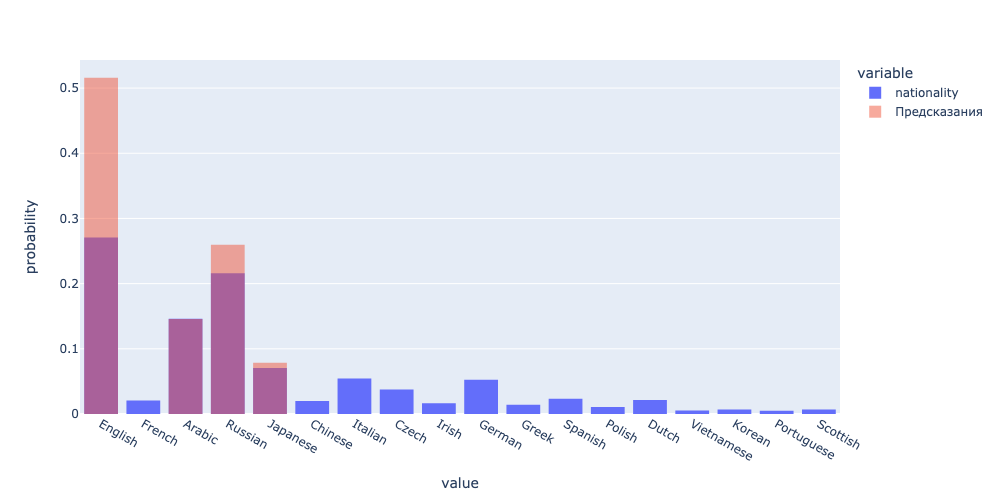

In [142]:
fig = px.histogram(surnames.nationality, histnorm='probability')
fig.add_histogram(x=answers, histnorm='probability', opacity=0.5, name='Предсказания')
fig.update_layout(barmode='overlay')
fig.show(renderer='png', width=1000)

In [ ]:
# задание абсолютно некорректное
# сохраним в гите это решение и идем дальше

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [ ]:
class Vocab:
    def __init__(self, data):
        self.idx_to_token = ...
        self.token_to_idx = ...
        self.vocab_len = ...

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, review):
        '''Генерирует представление отзыва review при помощи бинарного кодирования (см. 1.2)'''

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return ...